<a href="https://colab.research.google.com/github/yur-hims/BankATMsystem/blob/main/FINALNOTEBOOK_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import random
import PIL
from PIL import Image
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
BASEIMAGE = 'BASE IMAGE'
EXTENSIONBASE = '.jpg'
TARGETIMAGE = 'TARGET IMAGE'
EXTENSIONTARGET = '.jpg'

In [4]:
def generateColorHistogram(image,extension):
  img = Image.open(image+extension, 'r')
  plt.figure(figsize=(10,6))
  histogram_blue = cv2.calcHist([img],[0],None,[256],[0 ,256])
  plt.plot(histogram_blue, color='blue')
  histogram_green = cv2.calcHist([img],[1],None,[256],[0,256])
  plt.plot(histogram_green, color='green')
  histogram_red = cv2.calcHist([img],[2],None,[256],[0,256])
  plt.plot(histogram_red, color='red')
  plt.title('Intensity Histogram - Original Target Image', fontsize=20)
  plt.xlabel('pixel values', fontsize=16)
  plt.ylabel('pixel count', fontsize=16)
  plt.show()

def getImageMatrix_gray(image,extension):
  im = Image.open(image+extension).convert('LA')
  pix = im.load()
  image_size = im.size
  image_matrix = []
  for width in range(int(image_size[0])):
    row = []
    for height in range(int(image_size[1])):
      row.append((pix[width,height]))
      image_matrix.append(row)
    return image_matrix, image_size[0], image_size[1]

def autoCorrelation(image,extension):
  ImageMatrix,image_size = getImageMatrix_gray(image,extension)
  samples_x = []
  samples_y = []
  for i in range(1024):
    x = random.randint(0,image_size-2)
    y = random.randint(0,image_size-1)
    samples_x.append(ImageMatrix[x][y])
    samples_y.append(ImageMatrix[x+1][y])
  plt.figure(figsize=(10,8))
  plt.scatter(samples_x,samples_y,s=2)
  plt.title('Adjacent Pixel Autocorrelation - Original Image', fontsize=20)
  plt.show()


In [5]:
from PIL import Image, ImageOps


def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<=img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<=img.shape[0] else img.shape[0]
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2)
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	cv2.imwrite('READJUSTED.png',crop_img)
	return crop_img

In [6]:

def henonMapEnc(image,extension,x0,y0):
    im = Image.open(image+extension)
    px = im.load()
    w, h = im.size

    #y0 = 0.11
    #x0 = 0.1
    a = 1.4
    b = 0.3
    ncoords = []

    for i in range(0, h * w):
        x = 1 - 1.4 * pow(x0, 2) + y0
        y = 0.3 * x0
        xr = int(('%.12f' % (x))[5:9]) % w
        yr = int(('%.12f' % (y))[5:9]) % h
        ncoords.append((xr, yr))
        x0 = float('%.14f' % (x))
        y0 = float('%.14f' % (y))

    ncoords.reverse()

    for i in range(0, h * w):
        (xr, yr) = ncoords[i]
        j = h * w - i - 1
        p = px[j % w, int(j / w)]
        pr = px[xr, yr]
        px[j % w, int(j / w)] = pr
        px[xr, yr] = p

    im.save('encrypted_target.png')


#HENON MAP DECRYPTION
def henonMapDec(extension,x0,y0):
    im = Image.open('encrypted_target.png')#+extension)
    px = im.load()
    w, h = im.size

    #y0 = 0.11
    #x0 = 0.1
    """
    Flattening to linear using one loop
    """
    for i in range(0, h * w):
        x = 1 - 1.4 * pow(x0, 2) + y0
        y = 0.3 * x0
        x0 = float('%.14f' % (x))
        y0 = float('%.14f' % (y))
        xr = int(('%.11f' % (x))[5:9]) % w
        yr = int(('%.11f' % (y))[5:9]) % h

        p = px[i % w, int(i / w)]
        pr = px[xr, yr]
        px[i % w, int(i / w)] = pr
        px[xr, yr] = p

    im.save('decrypted_target.png', progressive=False, quality=100)


In [ ]:
def hide(image,extension):
# img1 and img2 are the
# two input images
  img1 = cv2.imread(image+extension) #IMAGE TO HIDE IN
  #img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
  img2 = cv2.imread('encrypted_target.png') #IMAGE TO HIDE
  #img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
  for i in range(img2.shape[0]):
    for j in range(img2.shape[1]):
      for l in range(3):
				# v1 and v2 are 8-bit pixel values
				# of img1 and img2 respectively
        v1 = format(img1[i][j][l], '08b')
        v2 = format(img2[i][j][l], '08b')

				# Taking 4 MSBs of each image
        v3 = v1[:4] + v2[:4]

        img1[i][j][l]= int(v3, 2)
  cv2.imwrite('steg.png', img1)
#%%
# Decryption function
def reveal(extensionBase, extensionTarget):
	# Encrypted image
  img = cv2.imread('READJUSTED.png')
  #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  width = img.shape[0]
  height = img.shape[1]
	# img1 and img2 are two blank images
  img1 = np.zeros((width, height, 3), np.uint8)
  img2 = np.zeros((width, height, 3), np.uint8)
  for i in range(width):
    for j in range(height):
      for l in range(3):
        v1 = format(img[i][j][l], '08b')
        v2 = v1[:4] + chr(random.randint(0, 1)+48) * 4
        v3 = v1[4:] + chr(random.randint(0, 1)+48) * 4

				# Appending data to img1 and img2
        img1[i][j][l]= int(v2, 2)
        img2[i][j][l]= int(v3, 2)

	# These are two images produced from
	# the encrypted image
  cv2.imwrite('Base_re.png', img1)
  cv2.imwrite('Target_re.png', img2)

In [ ]:
def arnold_cat_en(img):
	h,w,_=img.shape
	n=max(h,w)
	encrypted_image = np.zeros([n,n,3])
	padding = ((0,n-h),(0,n-w),(0,0))
	img=np.pad(img,padding,mode='constant', constant_values=255)

	for x in range(n):
		for y in range(n):
			encrypted_image[x][y]=img[(2*x+y)%n][(y+x)%n]


	return encrypted_image

def arnold_cat_de(img):
	h,w,_=img.shape
	decrypted_image = np.zeros([h,w,3])
	#rectangular images are not allowed
	if h!=w:
		raise Exception("Expected a square image")

	for x in range(h):
		for y in range(h):
			decrypted_image[x][y]=img[(x-y)%h][((2*y)-x)%h]

	img=decrypted_image
	return decrypted_image



In [10]:
from google.colab import drive
drive.mount('/download (2).png')

ValueError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
img = Image.open(BASEIMAGE+EXTENSIONBASE)
img

FileNotFoundError: ignored

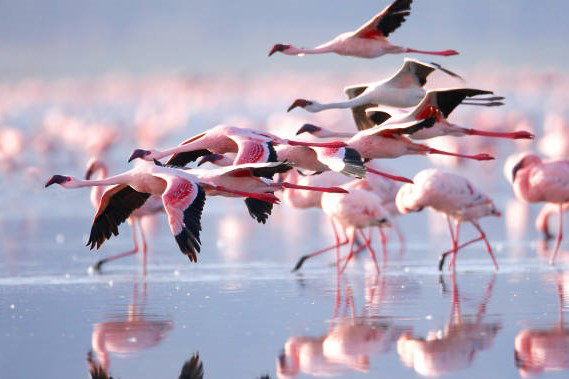

In [ ]:
img = Image.open(TARGETIMAGE+EXTENSIONTARGET)
img

-----------------------------------------------------------------------------------------------

In [ ]:
henonMapEnc(TARGETIMAGE,EXTENSIONTARGET,0.21,0.3201)

In [ ]:
hide(BASEIMAGE,EXTENSIONBASE)

In [ ]:
im = cv2.imread('steg.png')
im.shape

(379, 569, 3)

In [ ]:
rows = im.shape[0]
cols = im.shape[1]
ch = im.shape[2]
ndims = (rows,cols)
n = max(ndims)
m = min(ndims)
diff = n-m
pad = diff//2
flag = -1
if rows<cols:
  flag = 1
  im01 = resize_with_padding(Image.open('steg.png'),(cols,cols))
  im01.save('ADJUSTED.png')
elif rows>cols:
  flag = 1
  im02 = resize_with_padding(Image.open('steg.png'),(rows,rows))
  im02.save('ADJUSTED.png')

In [ ]:
ndims

(379, 569)

In [ ]:
arnoldKey = 13
hidden = cv2.imread('ADJUSTED.png')
#hidden = cv2.cvtColor(hidden,cv2.COLOR_BGR2RGB)
#enc = np.zeros([hidden.shape[0],hidden.shape[1]])
for i in range(arnoldKey):
  hidden = arnold_cat_en(hidden)
cv2.imwrite('encrypted_ADJUSTED.png',hidden)

True

----------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
hid = cv2.imread('encrypted_ADJUSTED.png')
#hid = cv2.cvtColor(hid,cv2.COLOR_BGR2RGB)
#dec = np.zeros([hid.shape[0],hid.shape[1]])
for i in range(13):
  hid = arnold_cat_de(hid)
cv2.imwrite('decrypted_ADJUSTED.png',hid)

True

In [ ]:
if flag==1:
  im = cv2.imread('decrypted_ADJUSTED.png')
  im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
  new = im[pad:n-pad][:][:]
  im03 = Image.fromarray(new,'RGB')
  im03.save('READJUSTED.png')

In [ ]:
reveal(EXTENSIONBASE,EXTENSIONTARGET)

In [ ]:
henonMapDec(EXTENSIONTARGET,0.21,0.3201)

#KEY SENSITIVITY

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Target Image: 


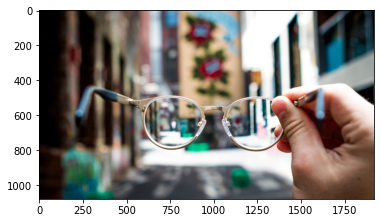

In [ ]:
img_target_unenc = mpimg.imread('target-image.jpg')
imgplot = plt.imshow(img_target_unenc)
print('Target Image: ')
plt.show()

Target Image- Henon Map Encryption 
Key: 0.21, 0.3201


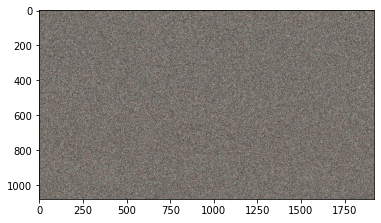

In [ ]:
img_target_enc = mpimg.imread('encrypted_target.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Encryption (Original) ')
print('Key: 0.21, 0.3201')
plt.show()

Target Image- Henon Map Encryption 
Key: 0.21, 0.3200


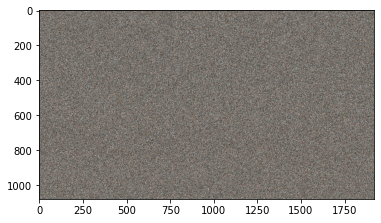

In [ ]:
img_target_enc = mpimg.imread('encrypted_target02.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Encryption ')
print('Key: 0.21, 0.3200')
plt.show()

Target Image- Henon Map Encryption 
Key: 0.211, 0.3201


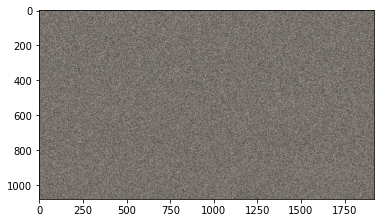

In [ ]:
img_target_enc = mpimg.imread('encrypted_target03.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Encryption ')
print('Key: 0.211, 0.3201')
plt.show()

Target Image- Henon Map Decryption 
Key: 0.21, 0.3201


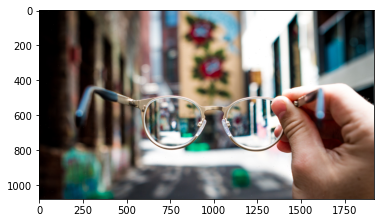

In [ ]:
img_target_enc = mpimg.imread('decrypted_target02.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Decryption ')
print('Key: 0.21, 0.3201')
plt.show()

Target Image- Henon Map Decryption 
Key: 0.211, 0.3201


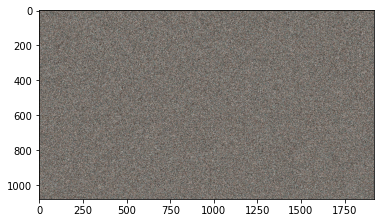

In [ ]:
img_target_enc = mpimg.imread('decrypted_target03.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Decryption ')
print('Key: 0.211, 0.3201')
plt.show()

Target Image- Henon Map Decryption 
Key: 0.21, 0.3200


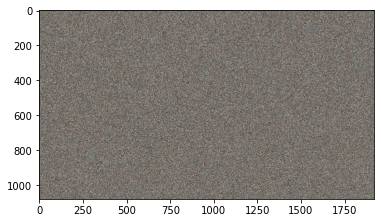

In [ ]:
img_target_enc = mpimg.imread('decrypted_target04.png')
imgplot = plt.imshow(img_target_enc)
print('Target Image- Henon Map Decryption ')
print('Key: 0.21, 0.3200')
plt.show()

---------------------------------------------------------------------------------------------------

Base Image:


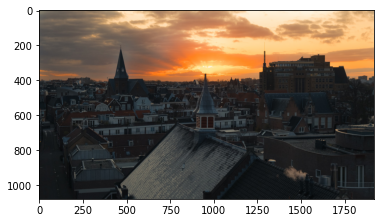

In [ ]:
img_base = mpimg.imread('base-image.jpg')
imgplot = plt.imshow(img_base)
print('Base Image:')
plt.show()

Target Image embedded within Base Image (Steganography): 


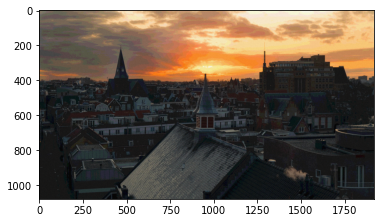

In [ ]:
img_base = mpimg.imread('steg.png')
imgplot = plt.imshow(img_base)
print('Target Image embedded within Base Image (Steganography): ')
plt.show()

Arnold Encryption Original Image: 


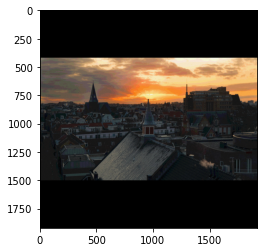

In [ ]:
img_arnold_unenc = mpimg.imread('ADJUSTED.png')
imgplot = plt.imshow(img_arnold_unenc)
print('Arnold Encryption Original Image: ')
plt.show()

Arnold Encryption- Encrypted Image (Original): 
Key: 13


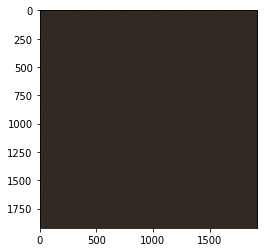

In [ ]:
img_arnold_enc = mpimg.imread('encrypted_ADJUSTED.png')
imgplot = plt.imshow(img_arnold_enc)
print('Arnold Encryption- Encrypted Image (Original): ')
print('Key: 13')
plt.show()

Arnold Encryption- Encrypted Image: 
Key: 12


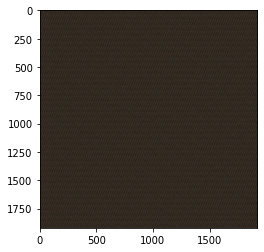

In [ ]:
img_arnold_enc = mpimg.imread('encrypted_ADJUSTED12.png')
imgplot = plt.imshow(img_arnold_enc)
print('Arnold Encryption- Encrypted Image: ')
print('Key: 12')
plt.show()

Arnold Encryption- Original Decrypted 
Key: 12


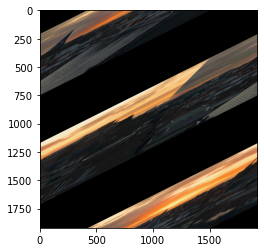

In [ ]:
img_arnold_dec = mpimg.imread('decrypted_ADJUSTED12.png')
imgplot = plt.imshow(img_arnold_dec)
print('Arnold Encryption- Original Decrypted ')
print('Key: 12')
plt.show()

Arnold Encryption- Original Decrypted 
Key: 13


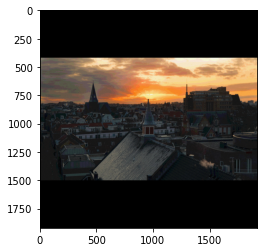

In [ ]:
img_arnold_dec = mpimg.imread('decrypted_ADJUSTED13.png')
imgplot = plt.imshow(img_arnold_dec)
print('Arnold Encryption- Original Decrypted ')
print('Key: 13')
plt.show()